# <center>MEFE 2023: Parcial Computacional <br> Tach y TiPiGi</center>
Estudiante: $\mathcal{A}\text{gustín} \:\mathcal{B}\text{rusco}$

<!-- Archivo complementario: [`MEFE/Codigo/utils.py`](https://github.com/agustinbrusco/MEFE/blob/master/Codigo/utils.py) -->

_Nota:_ En caso de querer correr el notebook, se recomiendo hacerlo secuencialmente (Kernel -> Restart & Run All) para reproducir todas las figuras al momento de su análisis.

In [1]:
# Importo librerías y defino formato de gráficos
import os
from typing import Sequence
import locale
from tqdm.notebook import tqdm

import numpy as np
from utils import histograma_discreto
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"  # Para gráficos de alta resolución
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["figure.dpi"] = 120
plt.rcParams["legend.fontsize"] = "medium"
plt.rcParams["axes.labelsize"] = "large"

# Inicializo un generador de números aleatorios para asegurar reproducibilidad
RNG = np.random.default_rng(
    # 42,  # La respuesta a la pregunta de la vida, el universo y todo lo demás
    2022,  # El de arriba me dió gráficos feos, este es mejor aunque no tan místico
)
# Separador de miles con puntos y coma decimal
locale_setting = locale.setlocale(locale.LC_ALL, "es_AR.UTF-8")

In [2]:
def simular_laberinto(probs_derecha: Sequence[float]) -> Sequence[int]:
    """Simula las decisiones que toma un ratón al recorrer el laberinto asumiendo que \
en cada intersección elige girar a la derecha con `probs_derecha[i]`. Devuelve las \
decisiones tomadas en cada intersección (0: izquierda, 1: derecha).
    """
    global RNG
    largo_laberinto = len(probs_derecha)
    decisiones = (RNG.random(largo_laberinto) < probs_derecha).astype(int)
    return decisiones


def salida_desde_decisiones(decisiones: Sequence[int]) -> int:
    """Modelando el laberinto como un "arbol binario", las salidas del laberinto \
pueden representarse cómo números del 0 al 2^(num_decisiones-1) - 1.
    """
    return int("".join(decisiones.astype("str")), base=2)


def simular_aprendizaje(
    num_decisiones: int,
    num_experimentos: int,
    f_aprendizaje: float,
    indice_recompensa: int,
) -> np.ndarray:
    # Inicializo lo array del modelo de aprendizaje del ratón.
    # En el i-ésimo experimento, el ratón tiene una probabilidad Mi(Dj) de girar a la
    # derecha en la j-ésima bifurcación.
    modelo_aprendido_derecha = np.full(
        shape=(num_experimentos + 1, num_decisiones),
        fill_value=0.5,  # P0(Di) = 0.5 para todo i
    )  # Asumiendo que su olfato no puede ayudarlo, el ratón comienza realizando giros 
    # al azar en cada bifurcación.
    
    # Inicializo el array de decisiones tomadas por el ratón.
    # En el i-ésimo experimento, el ratón tomó la decisión Xj en la j-ésima bifurcación.
    historia_decisiones = np.empty(shape=(num_experimentos, num_decisiones), dtype=int)
    for i in range(num_experimentos):
        modelo_probs_D = modelo_aprendido_derecha[i]  # Mi(Dj)
        decisiones = simular_laberinto(modelo_probs_D)  # Xj: 0->izquierda, 1->derecha
        historia_decisiones[i] = decisiones
        if salida_desde_decisiones(decisiones) == indice_recompensa:
            # Si llegó a la recompensa, aprende:
            modelo_probs_X = sum([  # Obtengo Mi(Xj) a partir de Mi(Dj)
                decisiones * modelo_probs_D,  # Xj*Mi(Dj)
                (1 - decisiones) * (1 - modelo_probs_D)  # (1-Xj)*Mi(Ij)
            ])
            # Aprendizaje: Mi+1(Xj) = Mi(Xj) * (1 + f)
            modelo_nuevas_probs_X = modelo_probs_X * (1 + f_aprendizaje)
            modelo_aprendido_derecha[i+1] = np.clip(  # Mi+1(Dj)
                a=sum([  # Obtengo Mi+1(Dj) a partir de Mi+1(Xj)
                    decisiones * modelo_nuevas_probs_X,  # Xj*Mi+1(Xj)
                    (1 - decisiones) * (1 - modelo_nuevas_probs_X)  # (1-Xj)*(1-Mi+1(Xj)
                ]),
                a_min=0, a_max=1,  # Clippeo para evitar probabilidades ∉ [0, 1]
            )
        else:
            # Si no llegó a la recompensa, no aprende:
            modelo_aprendido_derecha[i+1] = modelo_probs_D
    return historia_decisiones


# def estimar_probs_cond(
#     decisiones_objetivo: Sequence[int],  # X0, X1, ..., Xn
#     decisiones_observadas: np.ndarray,  # [X0, X1, ..., Xn] para cada experimento
# ) -> Sequence[float]:
#     """Devuelve una estimación de las probabilidades condicionales \
# P(Xj|X0, X1, ..., Xj-1) para cada j obtenida a partir de las decisiones observadas.
#     """
#     decisiones_iguales = (decisiones_observadas == decisiones_objetivo)
#     probs_condicionales = np.zeros_like(decisiones_objetivo, dtype=float)
#     probs_condicionales[0] = decisiones_iguales[:, 0].mean()  # P(X0)
#     for j in range(1, len(decisiones_objetivo)):
#         # Para cada Xj cuento el número de experimentos en los que se tomaron las
#         # mismas decisiones X0, X1, ..., Xj y normalizo por la fracción de veces que se 
#         # tomaron esas decisiones X0, X1, ..., Xj-1.
#         probs_condicionales[j] = (
#             decisiones_iguales[:, :j+1].all(axis=1).mean()  # P(interseccion)
#             / decisiones_iguales[:, :j].all(axis=1).mean()  # P(cond)
#         )
#     return probs_condicionales 


# def curva_aprendizaje(
#     decisiones_observadas: np.ndarray,  # [X0, X1, ..., Xn] para cada experimento
#     decisiones_objetivo_constante = None,
# ) -> Sequence[float]:
#     ll_vals = np.empty(len(decisiones_observadas), dtype=float)
#     for i, decisiones_objetivo in enumerate(decisiones_observadas):
#         probs_cond = (
#             decisiones_observadas == decisiones_objetivo
#         ).all(axis=1).mean()
#         ll_vals[i] = np.log(probs_cond.prod())
#     return ll_vals

def curva_aprendizaje(
    decisiones_observadas: np.ndarray,  # [X0, X1, ..., Xn] para cada experimento
) -> Sequence[float]:
    ll_vals = np.empty(len(decisiones_observadas), dtype=float)
    for i, decisiones_objetivo in enumerate(decisiones_observadas):
        prob_decisiones_hasta_i = (
            decisiones_observadas[:i+1] == decisiones_objetivo
        ).all(axis=1).mean()
        ll_vals[i] = np.log(prob_decisiones_hasta_i)
    return ll_vals


# def set_tick_fmt(ax: plt.Axes, axis: str) -> None:
    

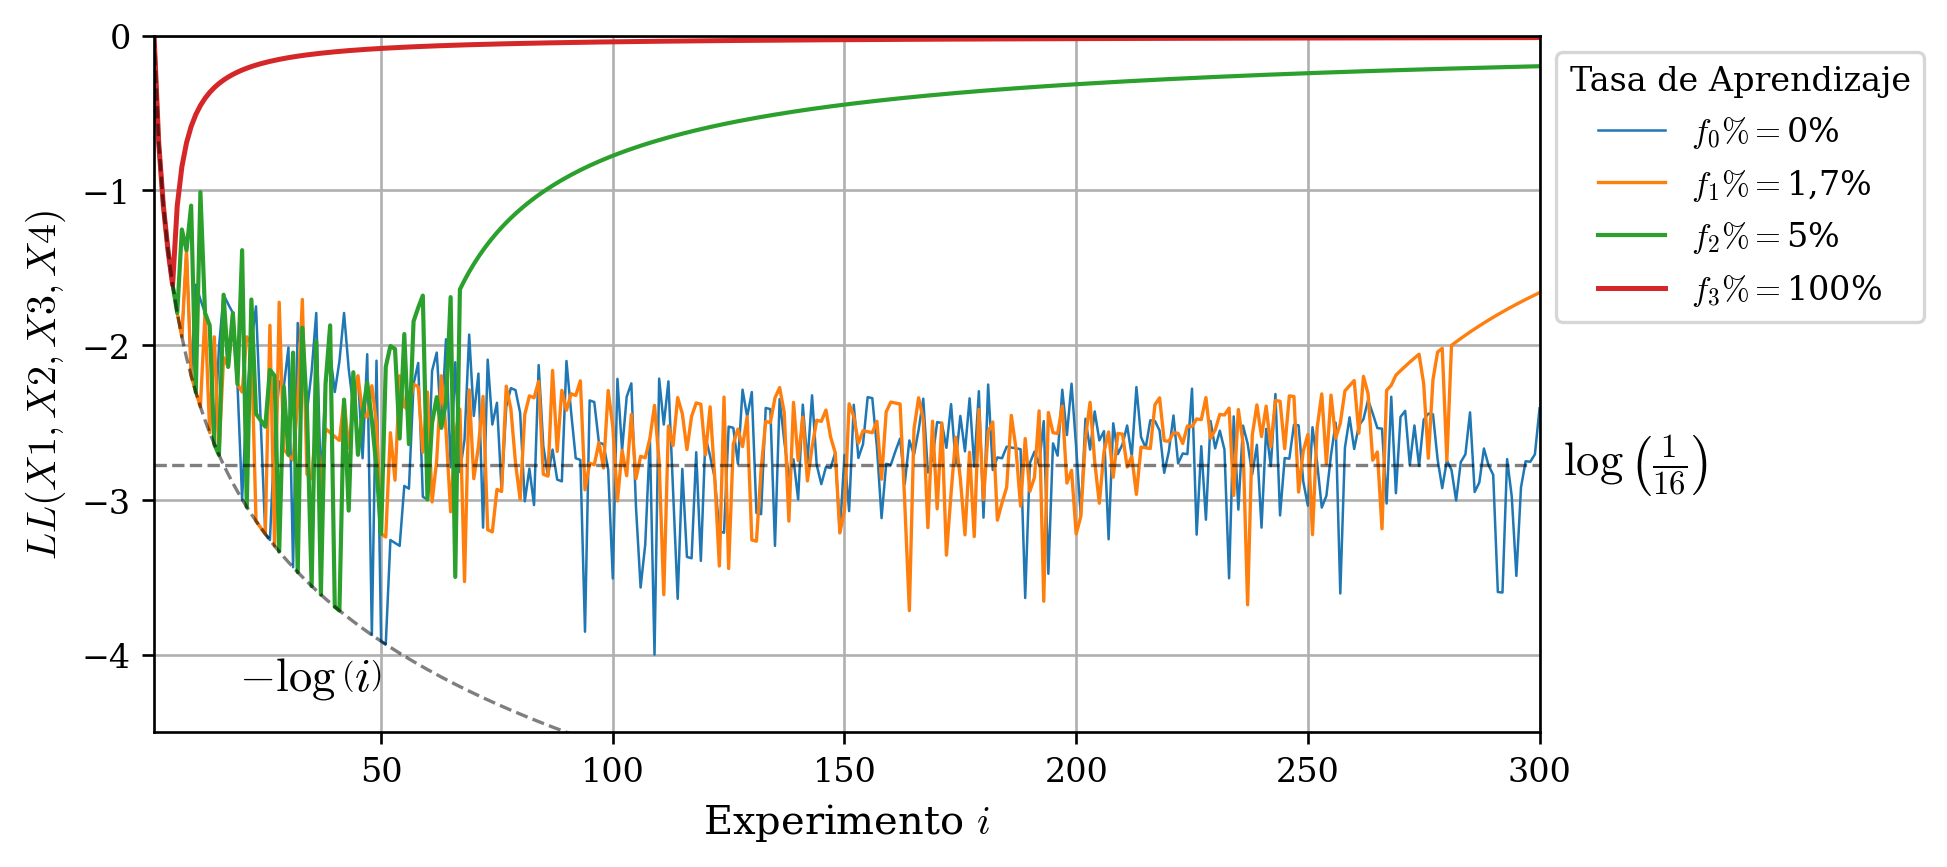

In [3]:
n_decisiones = 4
n_experimentos = 300
idx_recompensa = 3  # I1×2³ + I2×2² + D3×2¹ + D4×2⁰ = 0×2³ + 0×2² + 1×2¹ + 1×2⁰
f_vals = [0, 0.017, 0.05, 1]
f_tags = ["0", "1,7", "5", "100"]
f_style = ["-", "-", "-", "-"]
f_lw = [0.75, 1, 1.25, 1.5]

fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), constrained_layout=True)
indices_experimentos = np.arange(1, n_experimentos + 1)
for idx, f_aprendizaje in enumerate(f_vals):
    decisiones_simuladas = simular_aprendizaje(
        num_decisiones=n_decisiones,
        num_experimentos=n_experimentos,
        f_aprendizaje=f_aprendizaje,
        indice_recompensa=idx_recompensa,
    )
    valores_curva = curva_aprendizaje(decisiones_simuladas)
    ax.plot(
        indices_experimentos,
        valores_curva,
        ls=f_style[idx], lw=f_lw[idx],
        label=f"$f_{idx}\%=${f_tags[idx]}%",
    )

# ax.plot(indices_experimentos, np.log((indices_experimentos - 60)/indices_experimentos),
#         ls="--", lw=1, color="k",
#         alpha=0.5)
ax.plot(
    indices_experimentos, np.log(1/indices_experimentos),
    ls="--", lw=1, color="k", alpha=0.5,
)
ax.text(
    305, -2*np.log(n_decisiones),
    s=r"$\log\left(\frac{1}{"+f"{2**n_decisiones}"+r"}\right)$",
    va="center", ha="left", color=f"k", fontsize=14,
)
ax.axhline(
    np.log(1/2**n_decisiones),
    ls="--", lw=1, color=f"k", alpha=0.5,
)
ax.text(
    50, -4,
    s=r"$-\log\left(i\right)$",
    va="top", ha="right", color=f"k", fontsize=14,
)
ax.grid(True)
ax.legend(title="Tasa de Aprendizaje", bbox_to_anchor=(1, 1), loc="upper left")
ax.set_xlabel("Experimento $i$")
ax.set_xlim(1, n_experimentos)
ax.set_ylabel("$LL(X1, X2, X3, X4)$")
ax.set_ylim(top=0, bottom=-4.5)
ax.set_yticks(np.arange(0, -4-1, -1))
plt.show()
fig.savefig("figuras/curvas_de_aprendizaje.png", dpi=300, bbox_inches="tight")

In [4]:
0.5*(1+(1.7/100))**42

1.0149625712822226

In [5]:
# n_decisiones = 4
# n_experimentos = 300
# idx_recompensa = 3  # I1×2³ + I2×2² + D3×2¹ + D4×2⁰ = 0×2³ + 0×2² + 1×2¹ + 1×2⁰
# f_vals = [0, 0.015, 0.05, 1]
# # n_decisiones = 5
# # n_experimentos = 500
# # idx_recompensa = 3  # I1×2³ + I2×2² + D3×2¹ + D4×2⁰ = 0×2³ + 0×2² + 1×2¹ + 1×2⁰
# # f_vals = [0, 0.025, 0.05, 1]

# fig, axs = plt.subplots(3, 1, figsize=(8, 9), constrained_layout=True)
# axs[0].set_title("Curvas de Aprendizaje")
# axs[1].set_title("Curvas de Variación de Aprendizaje")
# axs[2].set_title("Distribución $\Delta{LL}$")
# indices_experimentos = np.arange(1, n_experimentos + 1)
# for idx, f_aprendizaje in enumerate(f_vals):
#     decisiones_simuladas = simular_aprendizaje(
#         num_decisiones=n_decisiones,
#         num_experimentos=n_experimentos,
#         f_aprendizaje=f_aprendizaje,
#         indice_recompensa=idx_recompensa,
#     )
#     valores_curva = curva_aprendizaje(decisiones_simuladas)
#     axs[0].plot(
#         indices_experimentos,
#         valores_curva,
#         "-", lw=1,
#         label=f"$f_{idx}=${f_aprendizaje:n}",
#     )
#     axs[1].plot(
#         indices_experimentos[1:],
#         np.diff(valores_curva),
#         "-", lw=1,
#         label=f"$f_{idx}=${f_aprendizaje:n}",
#     )
#     axs[2].hist(
#         np.diff(valores_curva),
#         bins=50,
#         histtype="step", lw=1,
#         label=f"$f_{idx}=${f_aprendizaje:n}",
#     )    
# axs[0].axhline(
#     np.log(1/2**n_decisiones),
#     ls="--", lw=1, color=f"k",
# )
# axs[0].text(2, -2*np.log(n_decisiones)-0.05,
#             s=r"$\log\left(\frac{1}{"+f"{2**n_decisiones}"+r"}\right)$",
#             va="top", ha="left", color=f"k", fontsize=7)
# axs[0].grid(True)
# axs[0].legend(title="Tasa de Aprendizaje", bbox_to_anchor=(1, 1), loc="upper left")
# axs[0].set_xlabel("Experimento")
# axs[0].set_xlim(1, n_experimentos)
# axs[0].set_ylabel("$LL(X1, X2, X3, X4)$")
# axs[0].set_ylim(top=0)
# # yticks = axs[0].get_yticks()
# # axs[0].set_yticks([*yticks, np.log(1/2**n_decisiones)])
# # axs[0].set_yticklabels([*yticks.astype(int), r"$\log\left(\frac{1}{"+f"{2**n_decisiones}"+r"}\right)$"])
# axs[1].grid(True)
# axs[1].legend(title="Tasa de Aprendizaje", bbox_to_anchor=(1, 1), loc="upper left")
# axs[1].set_ylabel("$\Delta_i{LL(X1, X2, X3, X4)}$")
# axs[1].set_xlim(1, n_experimentos)
# axs[2].grid(True)
# axs[2].legend(title="Tasa de Aprendizaje", bbox_to_anchor=(1, 1), loc="upper left")

# plt.show()

In [6]:
n_decisiones = 4
n_experimentos = 300
idx_recompensa = 3
f_vals = np.array([0, 0.017, 0.05, 1])
N_SIMULACIONES = 10_000
results_dir = f"resultados/{n_decisiones}dec_{n_experimentos}exp_{N_SIMULACIONES}sim"
if not os.path.exists(results_dir):
    os.mkdir(results_dir.split("/")[0])
    os.mkdir(results_dir)
f_stat = np.empty((len(f_vals), N_SIMULACIONES), dtype=float)
curvas_calculadas = np.empty((len(f_vals), N_SIMULACIONES, n_experimentos), dtype=float)
for f_idx, f_aprendizaje in tqdm(enumerate(f_vals), total=len(f_vals)):
    try:
        curvas_calculadas[f_idx, :, :] = np.load(
            f"{results_dir}/curvas_calculadas_{f_idx}.npy"
        )
        f_stat[f_idx, :] = np.sum(np.diff(curvas_calculadas[f_idx, :, :], axis=1) < 0, axis=1)
    except FileNotFoundError:
        for sim_idx in tqdm(range(N_SIMULACIONES), total=N_SIMULACIONES):
            decisiones_simuladas = simular_aprendizaje(
                num_decisiones=n_decisiones,
                num_experimentos=n_experimentos,
                f_aprendizaje=f_aprendizaje,
                indice_recompensa=idx_recompensa,
            )
            curvas_calculadas[f_idx, sim_idx, :] = curva_aprendizaje(
                decisiones_simuladas
            )
            f_stat[f_idx, sim_idx] = sum(
                np.diff(curvas_calculadas[f_idx, sim_idx, :]) < 0
            )
        np.save(
            f"{results_dir}/curvas_calculadas_{f_idx}.npy",
            curvas_calculadas[f_idx, :, :]
        )

  0%|          | 0/4 [00:00<?, ?it/s]

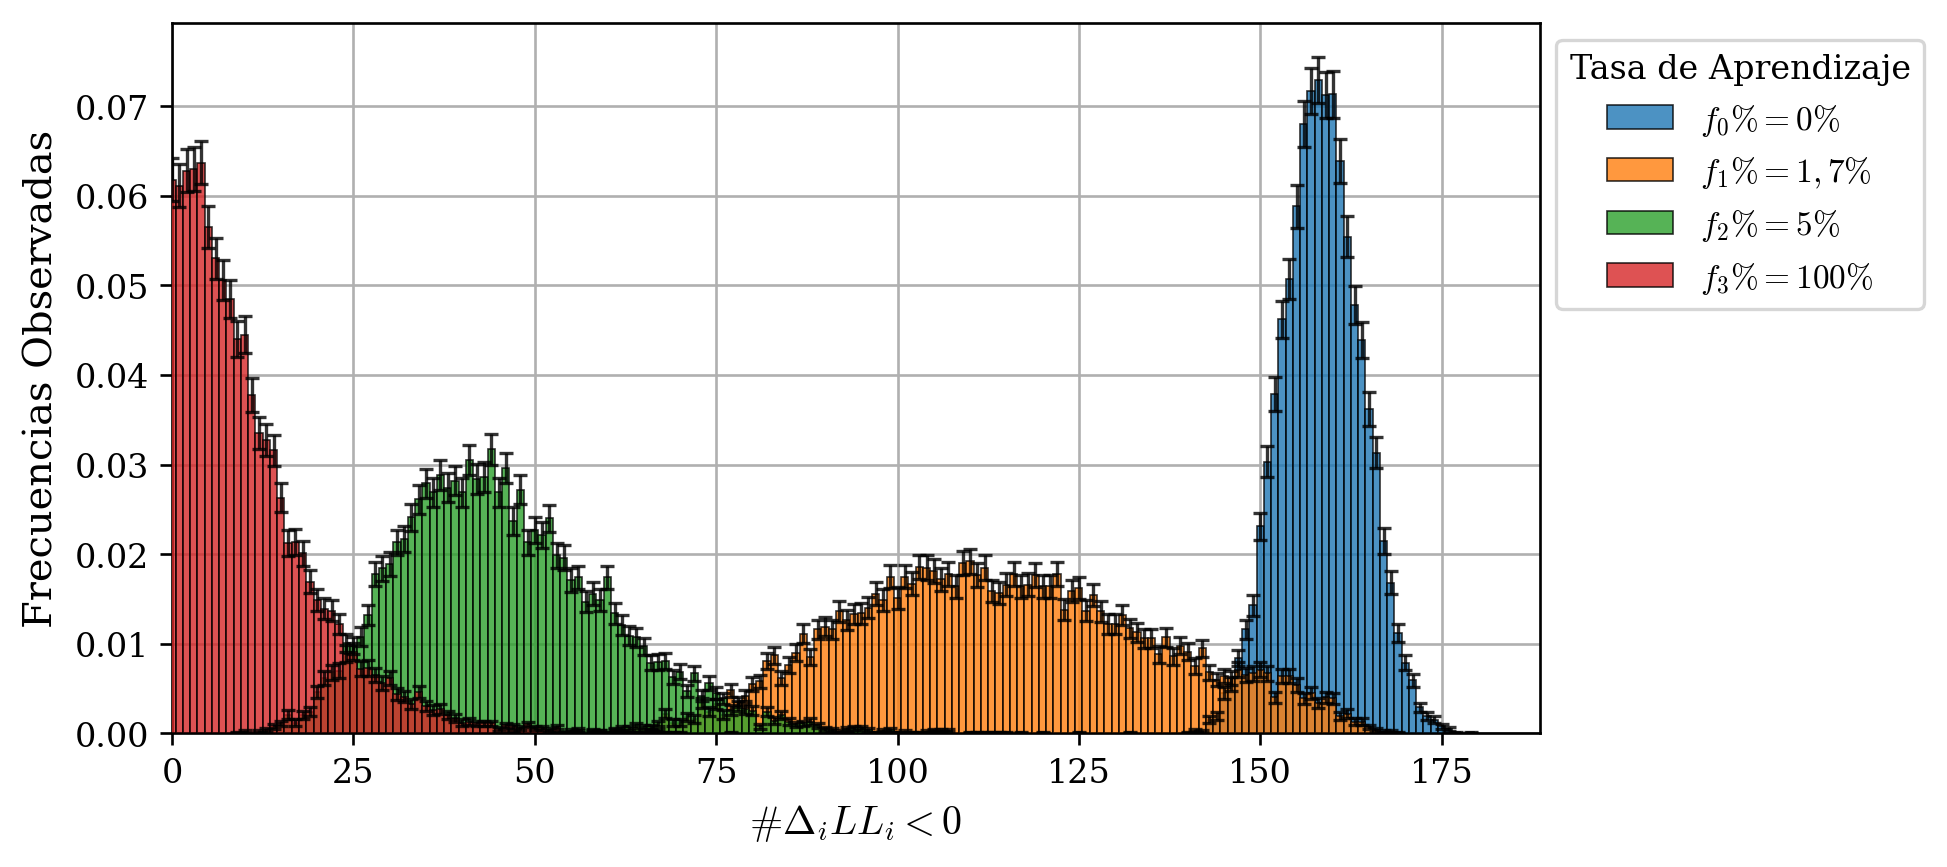

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), constrained_layout=True)
# ax.set_title(r"Distribución $\Delta_i{LL} < 0$")
for f_idx, f_aprendizaje in enumerate(f_vals):
    histograma_discreto(
        f_stat[f_idx, :],
        ax=ax,
        label=f"$f_{f_idx}\%={f_tags[f_idx]}\%$",
        color=f"C{f_idx}",
        ecolor="k",#f"C{f_idx}",
        elinewidth=1,
        ecapsize=2,
        alpha=0.8,
        zorder=5
    )
ax.grid(True)
ax.legend(title="Tasa de Aprendizaje", bbox_to_anchor=(1, 1), loc="upper left")
ax.set_xlabel("$\#\Delta_i{LL_i} < 0$")
ax.set_xlim(left=0)
ax.set_ylabel("Frecuencias Observadas")
ax.set_ylim(bottom=0)
plt.show()
fig.savefig(f"figuras/distribucion_delta_ll.png", dpi=300, bbox_inches="tight")

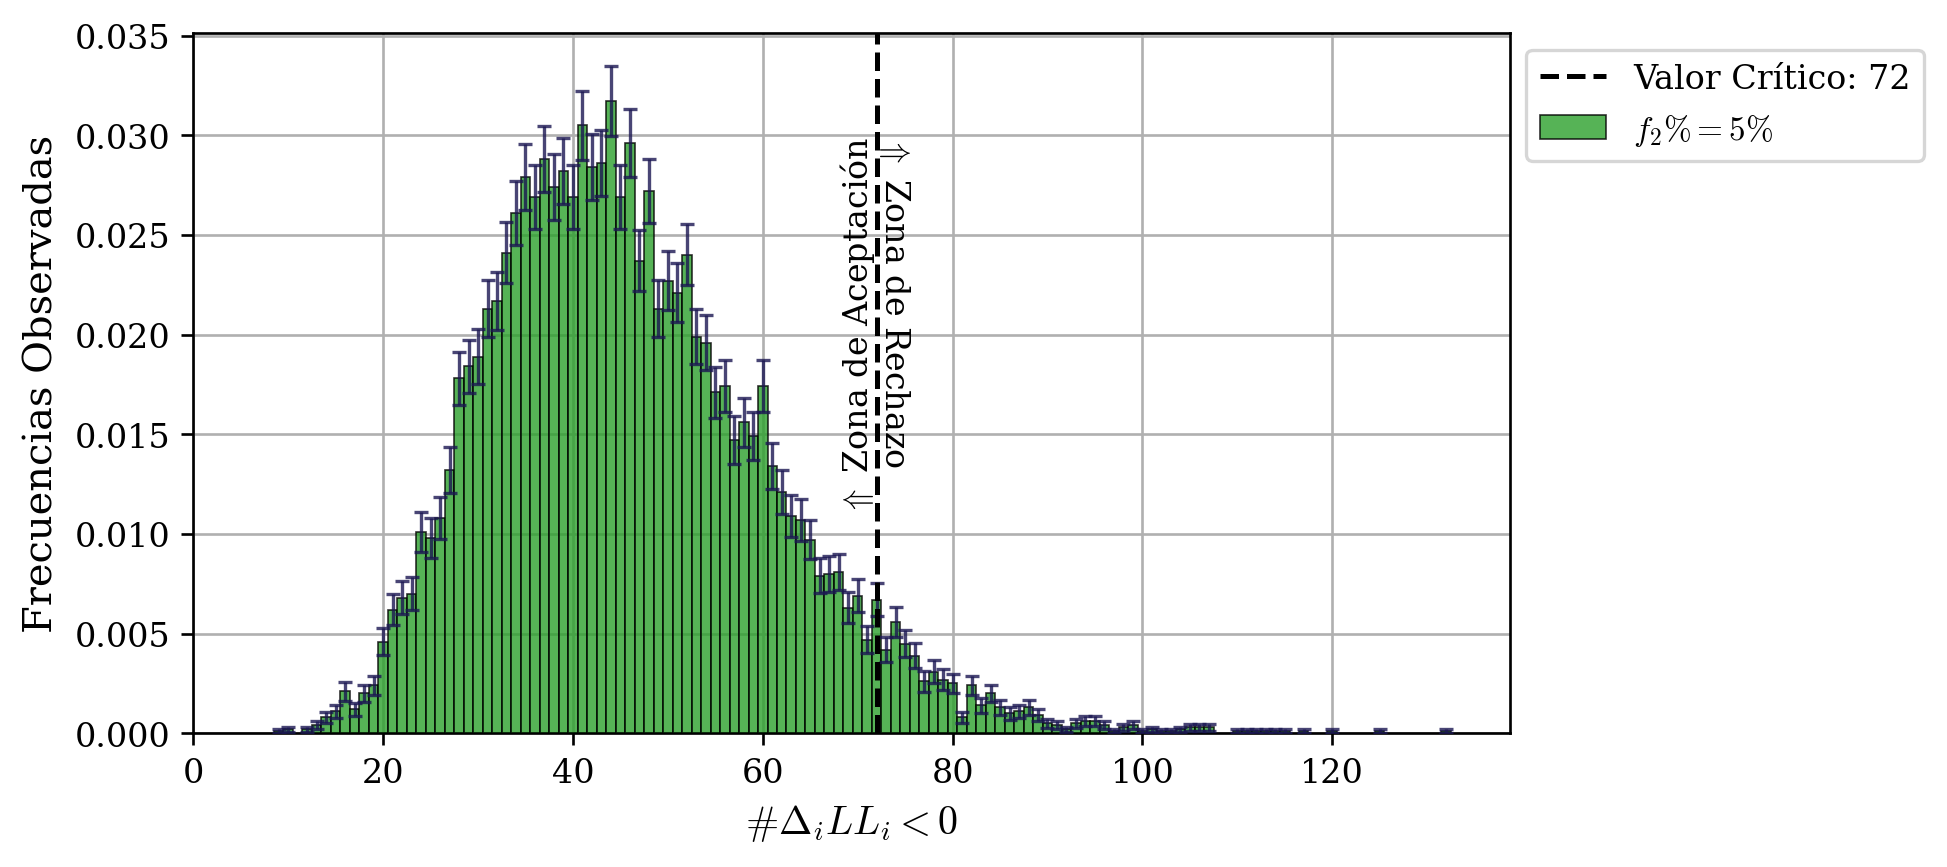

In [8]:
f_idx = 2
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), constrained_layout=True)
# ax.set_title(r"Distribución $\Delta_i{LL} < 0$")
significancia = 0.05
valor_critico = np.quantile(f_stat[f_idx, :], 1 - significancia)
histograma_discreto(
    f_stat[f_idx, :],
    ax=ax,
    label=f"$f_{2}\%={f_tags[f_idx]}\%$",
    color=f"C{f_idx}",
    # ecolor=f"C{f_idx}",
    elinewidth=1,
    ecapsize=2,
    alpha=0.8,
    zorder=5
)
ax.axvline(valor_critico, color="k", linestyle="--",
           label=f"Valor Crítico: {valor_critico:.0f}", zorder=10)
ax.text(valor_critico, 0.030,
        s=r"$\Uparrow$ Zona de Rechazo",
        ha="left", va="top", rotation=270)
ax.text(valor_critico, 0.030,
        s=r"$\Uparrow$ Zona de Aceptación",
        ha="right", va="top", rotation=90)
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 1), loc="upper left")
ax.set_xlabel("$\#\Delta_i{LL_i} < 0$")
ax.set_xlim(left=0)
ax.set_ylabel("Frecuencias Observadas")
ax.set_ylim(bottom=0)
plt.show()
fig.savefig(f"figuras/zonas_test_f2.png", dpi=300, bbox_inches="tight")

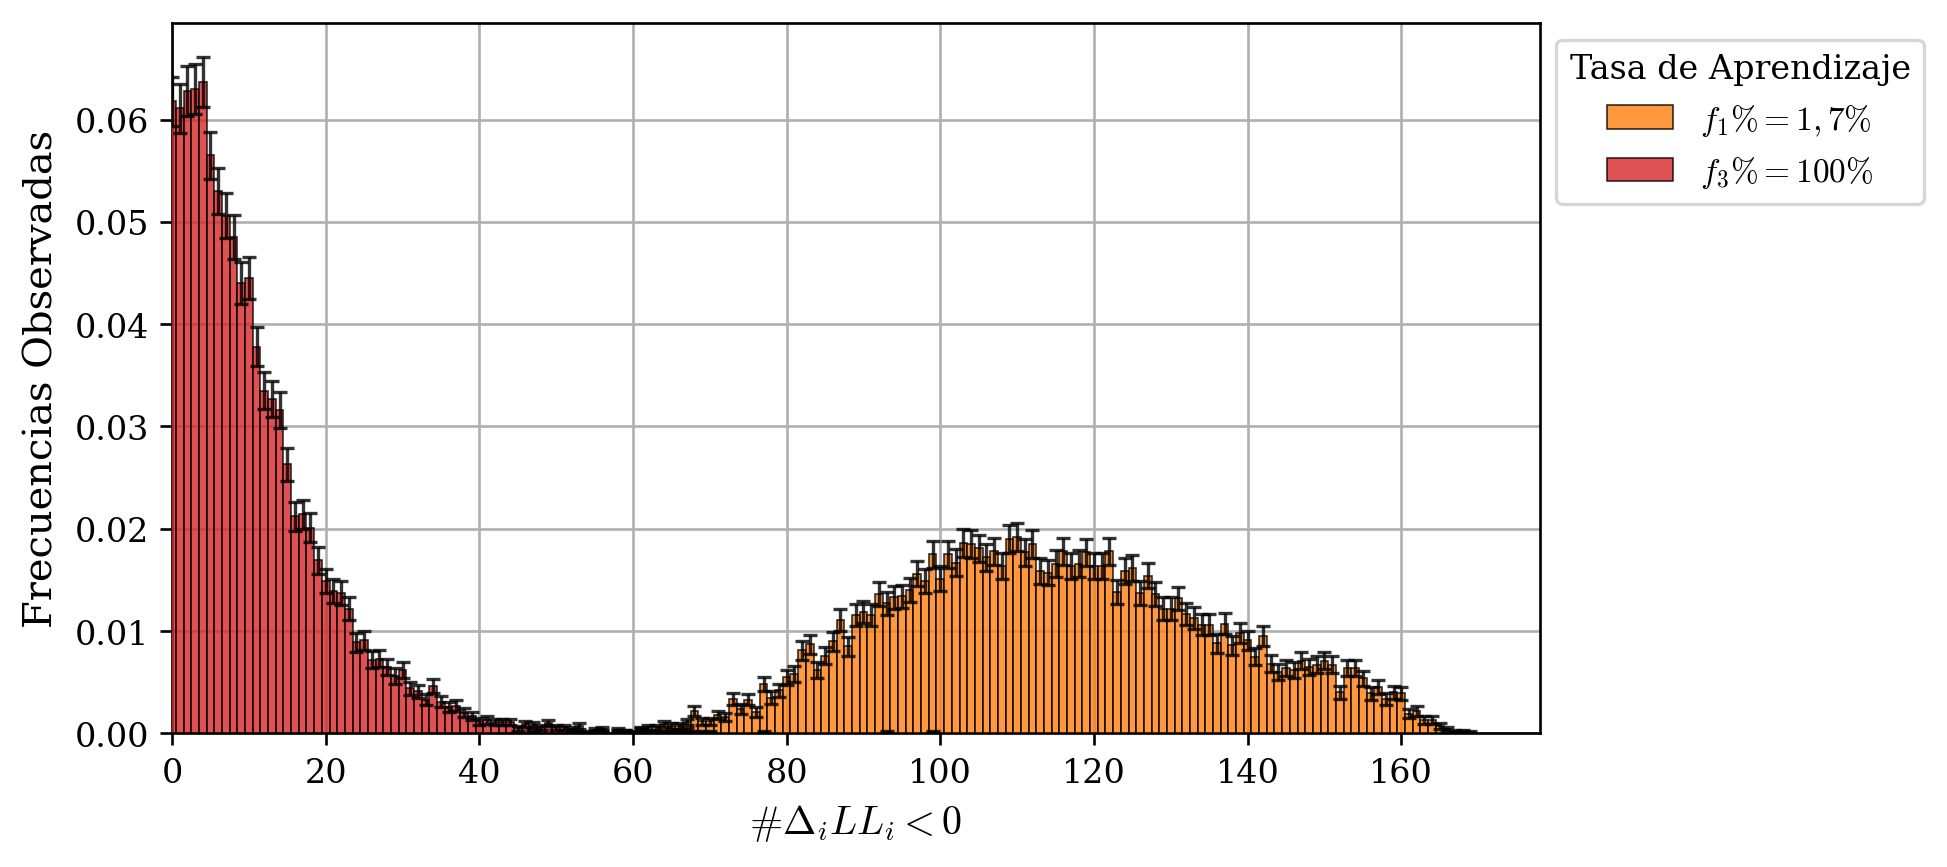

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3.5), constrained_layout=True)
# ax.set_title(r"Distribución $\Delta_i{LL} < 0$")
for f_idx, f_aprendizaje in enumerate(f_vals):
    if f_idx in [0, 2]:
        continue
    histograma_discreto(
        f_stat[f_idx, :],
        ax=ax,
        label=f"$f_{f_idx}\%={f_tags[f_idx]}\%$",
        color=f"C{f_idx}",
        ecolor="k",#f"C{f_idx}",
        elinewidth=1,
        ecapsize=2,
        alpha=0.8,
        zorder=5
    )
ax.grid(True)
ax.legend(title="Tasa de Aprendizaje", bbox_to_anchor=(1, 1), loc="upper left")
ax.set_xlabel("$\#\Delta_i{LL_i} < 0$")
ax.set_xlim(left=0)
ax.set_ylabel("Frecuencias Observadas")
ax.set_ylim(bottom=0)
plt.show()
fig.savefig(f"figuras/distribucion_delta_ll_f3_f1.png", dpi=300, bbox_inches="tight")

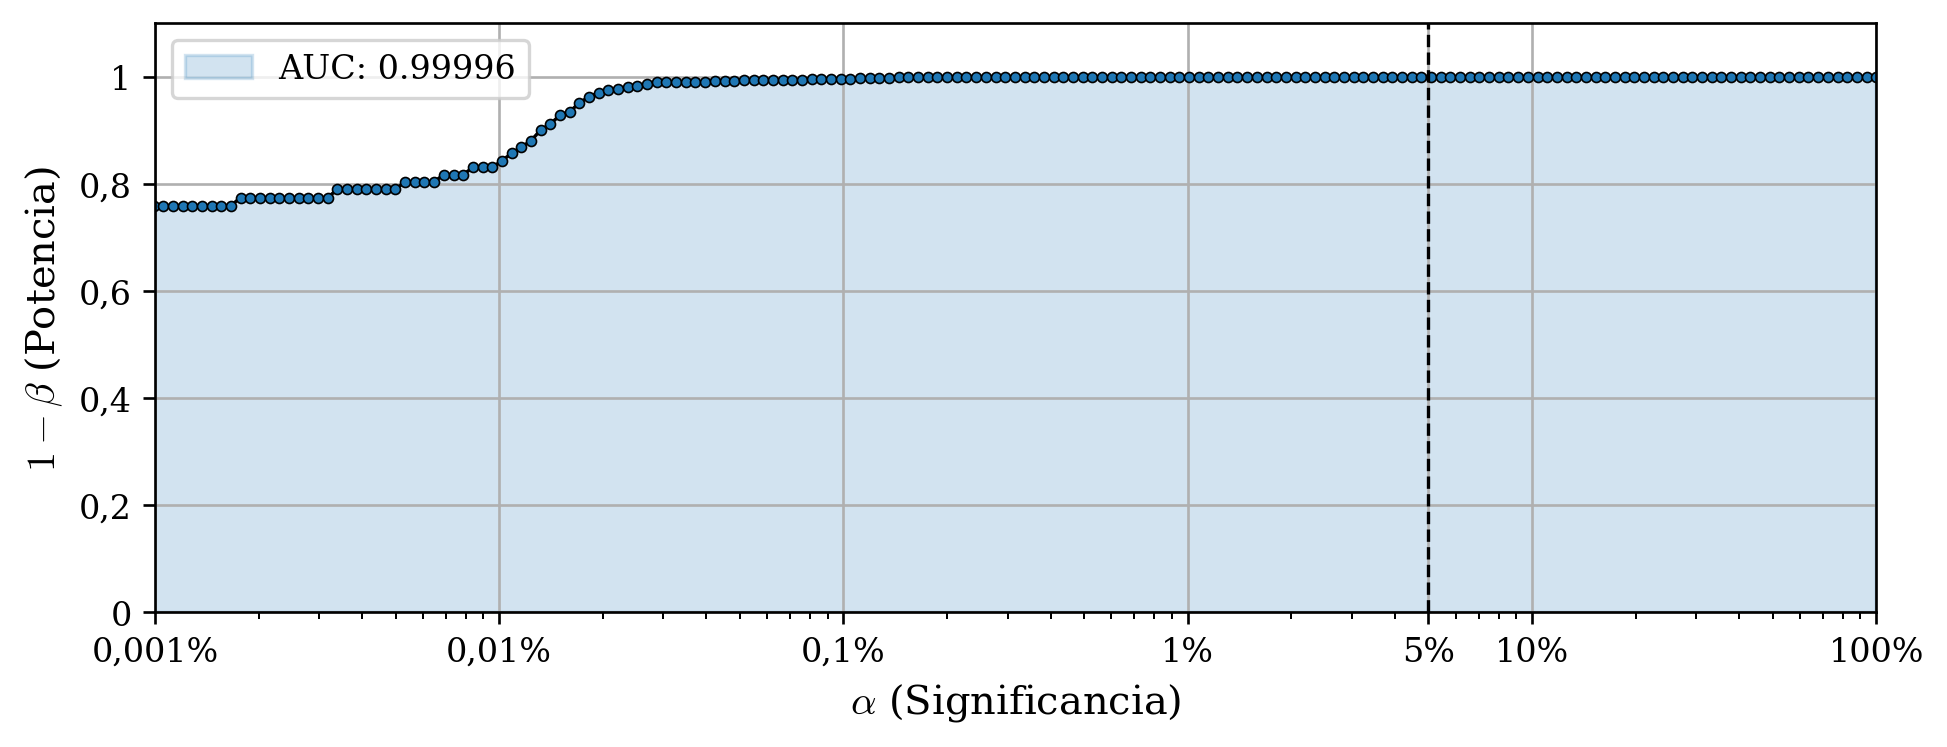

In [10]:
h0_idx = 3
h1_idx = 1
fig, ax = plt.subplots(1, 1, figsize=(8, 3), constrained_layout=True)
# ax.set_title("Curva de Potencia (ROC) del Test:\n$H_0: f_3 = 1$ vs $H_1: f_1 = 0.025$")
# ax.set_title("$H_0: f_3\% = 100\%$ vs $H_1: f_1\% = 1,7\%$")
alpha_vals = np.geomspace(1e-7, 1, 250)
critical_vals = np.quantile(f_stat[h0_idx, :], 1 - alpha_vals)
unique_vals, counts = np.unique(f_stat[h1_idx, :], return_counts=True)
potencia_vals = np.empty_like(alpha_vals)
for idx, valor_critico in enumerate(critical_vals):
    potencia_vals[idx] = counts[unique_vals > valor_critico].sum() / counts.sum()
ax.plot(alpha_vals, potencia_vals, ".-k", mfc="C0", mec="k", mew=0.5, lw=1)
ax.fill_between(alpha_vals, 0, potencia_vals, color="C0", alpha=0.2,
                label=f"AUC: {np.trapz(potencia_vals, alpha_vals):.5f}")
ax.axvline(0.05, ls="--", lw=1, color="k")
ax.grid(True)
ax.legend()
ax.set_xscale("log")
# ax.set_yscale("log")
ax.set_xlabel(r"$\alpha$ (Significancia)")
xticks = np.geomspace(1e-7, 1, 8)
ax.set_xticks([*xticks, 0.05])
ax.set_xticklabels(["0,00001%", "0,0001%", "0,001%", "0,01%", "0,1%", "1%", "10%", "100%", "5%"])
ax.set_xlim(left=1e-5, right=1)
ax.set_ylabel(r"$1 - \beta$ (Potencia)")
ax.set_ylim(bottom=0, top=1.1)
ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([f"{tick:n}" for tick in ax.get_yticks()])
plt.show()
fig.savefig(f"figuras/roc_test_f3_f1.png", dpi=300, bbox_inches="tight")

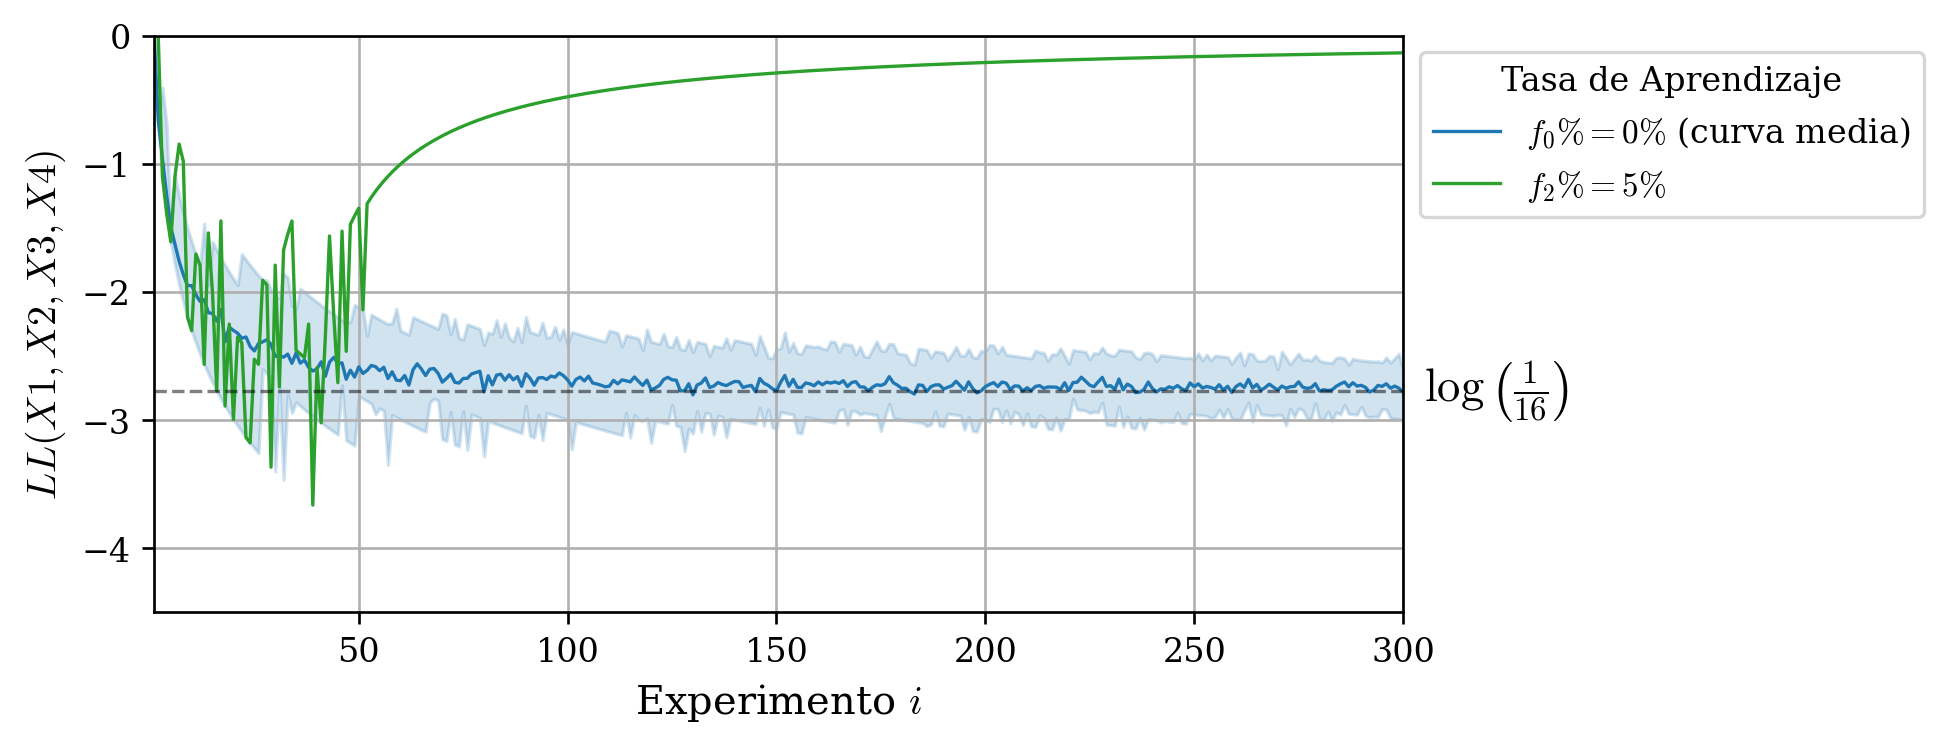

In [11]:
n_decisiones = 4
n_experimentos = 300
idx_recompensa = 3
f_vals = np.array([0, 0.025, 0.05, 1])
N_SIMULACIONES = 100
indices_experimentos = np.arange(1, n_experimentos+1)
curvas_f0 = np.empty((N_SIMULACIONES, n_experimentos))
for sim in range(N_SIMULACIONES):
    decisiones_f0 = simular_aprendizaje(
        num_decisiones=n_decisiones,
        num_experimentos=n_experimentos,
        f_aprendizaje=f_vals[0],
        indice_recompensa=idx_recompensa,
    )
    curvas_f0[sim, :] = curva_aprendizaje(decisiones_f0)
decisiones_f2 = simular_aprendizaje(
    num_decisiones=n_decisiones,
    num_experimentos=n_experimentos,
    f_aprendizaje=f_vals[2],
    indice_recompensa=idx_recompensa,
)
curva_f2 = curva_aprendizaje(decisiones_f2)
curva_media_f0 = curvas_f0.mean(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(8, 3), constrained_layout=True)
ax.plot(
    indices_experimentos,
    curva_media_f0,
    color="C0", lw=1,
    label=r"$f_{0}\%=0\%$ (curva media)",
)
ax.fill_between(
    indices_experimentos,
    # curvas_f0.min(axis=0),
    # curvas_f0.max(axis=0),
    # curva_media_f0 - curvas_f0.std(axis=0, ddof=1),
    # curva_media_f0 + curvas_f0.std(axis=0, ddof=1),
    np.quantile(curvas_f0, 0.16, axis=0),
    np.quantile(curvas_f0, 0.84, axis=0),
    alpha=0.2, color="C0"
)
ax.plot(indices_experimentos, curva_f2, color="C2", lw=1, label=r"$f_{2}\%=5\%$")
ax.axhline(
    np.log(1/2**n_decisiones),
    ls="--", lw=1, color=f"k", alpha=0.5,
)
ax.text(
    305, -2*np.log(n_decisiones),
    s=r"$\log\left(\frac{1}{"+f"{2**n_decisiones}"+r"}\right)$",
    va="center", ha="left", color=f"k", fontsize=14,
)
ax.grid(True)
ax.legend(title="Tasa de Aprendizaje", bbox_to_anchor=(1, 1), loc="upper left")
ax.set_xlabel("Experimento $i$")
ax.set_xlim(1, n_experimentos)
ax.set_ylabel("$LL(X1, X2, X3, X4)$")
ax.set_ylim(top=0, bottom=-4.5)
ax.set_yticks(np.arange(0, -4-1, -1))
plt.show()
fig.savefig("figuras/curvas_aprendizaje_f0_f2.png", dpi=300, bbox_inches="tight")

In [12]:
stat_f0 = sum(np.diff(curva_media_f0) < 0)
stat_f2 = sum(np.diff(curva_f2) < 0)

h0_idx = 0
unique_vals, counts = np.unique(f_stat[h0_idx, :], return_counts=True)
p_valor_curva_f2 = counts[unique_vals < stat_f2].sum() / counts.sum()
p_valor_curva_media_f0 = counts[unique_vals < stat_f0].sum() / counts.sum()
(stat_f2, p_valor_curva_f2), (stat_f0, p_valor_curva_media_f0)

((28, 0.0), (155, 0.2365))

In [13]:
N_SIMULACIONES = 10_000
p_vals = np.empty((2, N_SIMULACIONES))
h0_idx = 0
unique_vals, counts = np.unique(f_stat[h0_idx, :], return_counts=True)
for sim in range(N_SIMULACIONES):
    decisiones_f0 = simular_aprendizaje(
        num_decisiones=n_decisiones,
        num_experimentos=n_experimentos,
        f_aprendizaje=f_vals[0],
        indice_recompensa=idx_recompensa,
    )
    curvas_f0 = curva_aprendizaje(decisiones_f0)
    stat_f0 = sum(np.diff(curvas_f0) < 0)
    p_vals[0, sim] = counts[unique_vals < stat_f0].sum() / counts.sum()
    decisiones_f2 = simular_aprendizaje(
        num_decisiones=n_decisiones,
        num_experimentos=n_experimentos,
        f_aprendizaje=f_vals[2],
        indice_recompensa=idx_recompensa,
    )
    curva_f2 = curva_aprendizaje(decisiones_f2)
    stat_f2 = sum(np.diff(curva_f2) < 0)
    p_vals[1, sim] = counts[unique_vals < stat_f2].sum() / counts.sum()

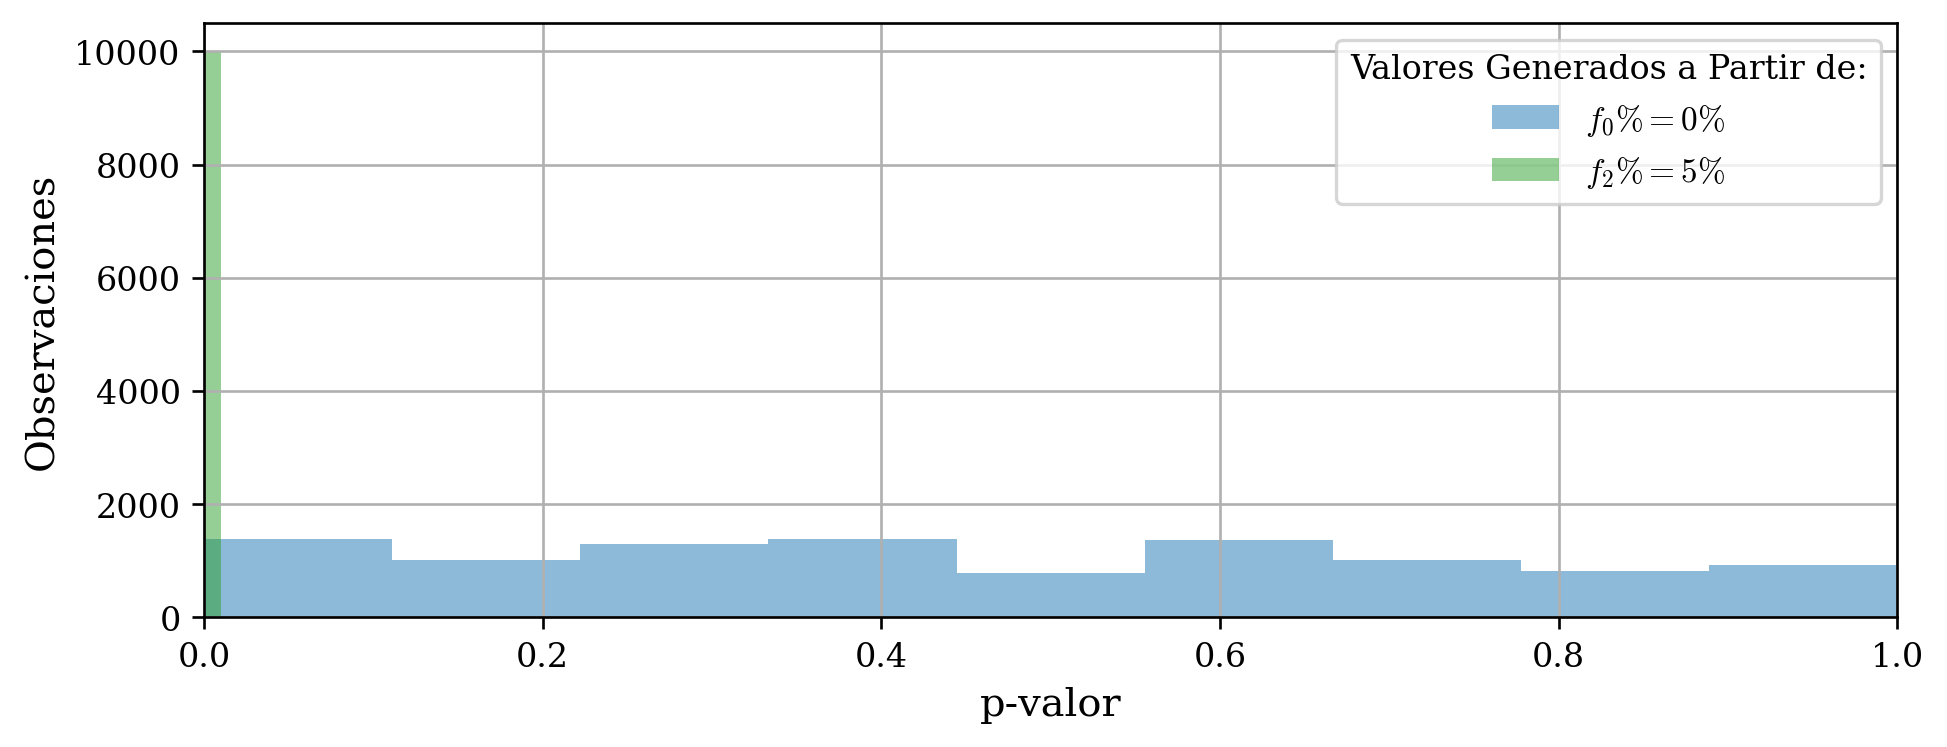

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3), constrained_layout=True)
ax.hist(p_vals[0, :], bins=np.linspace(0, 1, 10), color="C0", alpha=0.5, label=r"$f_{0}\%=0\%$")
ax.hist(p_vals[1, :], bins=np.linspace(0, 1, 100), color="C2", alpha=0.5, label=r"$f_{2}\%=5\%$")
ax.grid(True)
ax.legend(title="Valores Generados a Partir de:")
ax.set_xlabel("p-valor")
ax.set_xlim(0, 1)
ax.set_ylabel("Observaciones")
plt.show()
fig.savefig("figuras/p_valores_f0_f2.png", dpi=300, bbox_inches="tight")